In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
### Asignamos las coordenadas geográficas y creamos una lista de posición. 
# Además, generamos una red con datos de Open Street Map

mexico_city_map = Basemap(llcrnrlon=-99.4, llcrnrlat=19.1, urcrnrlon=-98.8, urcrnrlat=19.7, resolution='l', epsg=4326)

ecobici_coordenadas = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Dictionary/Cordenadas_Ecobici.csv")
ecobici_coordenadas = ecobici_coordenadas.rename(columns={'id':'source','Latitud':'longitud','Longitud':'latitud'})
pos =ecobici_coordenadas[['source','latitud','longitud']]
mx, my =mexico_city_map(ecobici_coordenadas[['longitud']],
                        ecobici_coordenadas[['latitud']])
ecobici_coordenadas[['longitud']]=mx
ecobici_coordenadas[['latitud']] = my
pos['location']=pos[['latitud','longitud']].apply(tuple,axis=1)
pos=pos[['source','location']]
pos_dic = dict(zip(pos['source'], pos['location']))

north, south, east, west = 19.4517, 19.3524, -99.1267, -99.2269
G_osm = ox.graph_from_bbox(north, south, east, west, network_type='walk')

C:\Users\benga\AppData\Local\Temp\ipykernel_15072\2833797477.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['location']=pos[['latitud','longitud']].apply(tuple,axis=1)


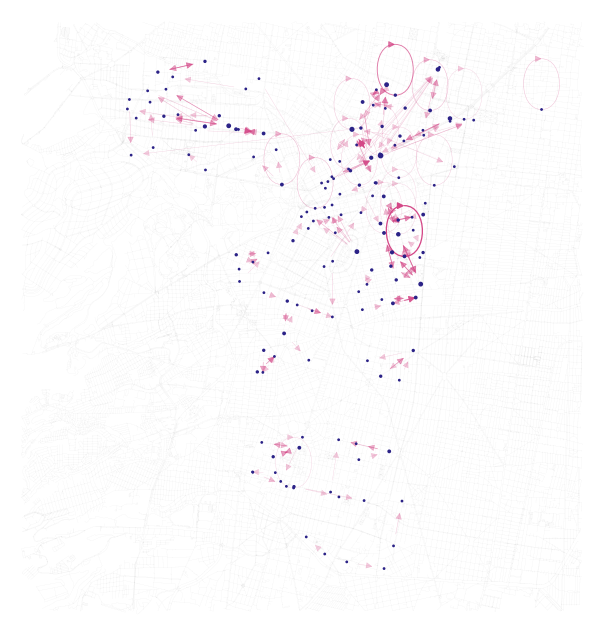

In [3]:
# Red para las mujeres en el año 2019
# Cargamos los datos para generar la lista del tamaño de los nodos

ecobici = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Clean/2019_Gen.csv")
# Condición de género
ecobici = ecobici[ecobici['Genero_Usuario']=='F']
ecobici = ecobici.rename(columns={'Ciclo_Estacion_Retiro':'source','Ciclo_Estacion_Arribo':'target'})
ecobici = ecobici[['source','Viajes']].groupby('source').sum().reset_index() 

# Estandarizamos el número de viajes 

ecobici['Viajes']=round(ecobici['Viajes']/400)
size_map_aux=ecobici

# Cargamos los datos para ajustar la red 

ecobici = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Clean/2019_Gen.csv")
ecobici = ecobici[ecobici['Genero_Usuario']=='F']
ecobici = ecobici.rename(columns={'Ciclo_Estacion_Retiro':'source','Ciclo_Estacion_Arribo':'target'})
edges = ecobici[['source', 'target','Viajes']].reset_index(drop=True) 
edges=edges.rename(columns={'Viajes':'weight'})

# Ajustamos la red dirigida con pesos

G=nx.from_pandas_edgelist(edges,source='source',target='target',edge_attr='weight',
                          create_using=nx.DiGraph())
nx.set_node_attributes(G, pos_dic, 'coord')

widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()


# Generamos una lsita para el tamaño de los nodos. 
#A mayor tamaño, mayor número de viajes que salieron de la estación 

size_map=[]
for node in G:
    try:
        aux=size_map_aux[size_map_aux['source']==node].iloc[0]['Viajes']
        size_map.append(aux)
    except: 
        aux=1
        size_map.append(aux)

# Creamos una lista de la transparencia de los enlaces. 
#A menor transparencia, mayor número de viajes

max_weight = max([G.edges[e]['weight'] for e in G.edges])
alpha=[]
for e in G.edges:
    alpha.append(G.edges[e]['weight'] / max_weight)
    

##### Graficamos la red usando como fondo la red de osm 

plt.rc('figure', figsize=(70,60))
plt.rcParams.update({'figure.figsize': (70,60)})
fig, ax = ox.plot_graph(G_osm, node_size=0, edge_color='#898d8d',edge_linewidth=0.1, bgcolor='w', show=False, close=False,edge_alpha=0.1)
nx.draw_networkx_nodes(G,pos=pos_dic,
                       ax=ax,
                       node_color='#2b2287', 
                       node_size =size_map)

nx.draw_networkx_edges(G,pos=pos_dic,
                       ax=ax,
                       edge_color='#d44787',
                       width=list(map(lambda x: x / 1500,widths.values())),
                       alpha=alpha);


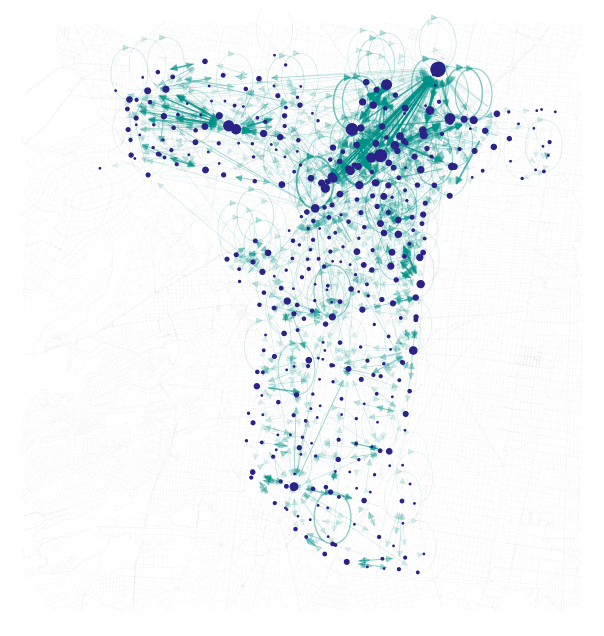

In [5]:
# Red para los hombres en el año 2019
# Cargamos los datos para generar la lista del tamaño de los nodos

ecobici = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Clean/2019_Gen.csv")
# Condición de género
ecobici = ecobici[ecobici['Genero_Usuario']=='M']
ecobici = ecobici.rename(columns={'Ciclo_Estacion_Retiro':'source','Ciclo_Estacion_Arribo':'target'})
ecobici = ecobici[['source','Viajes']].groupby('source').sum().reset_index() 

# Estandarizamos el número de viajes 

ecobici['Viajes']=round(ecobici['Viajes']/400)
size_map_aux=ecobici

# Cargamos los datos para ajustar la red 

ecobici = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Clean/2019_Gen.csv")
ecobici = ecobici[ecobici['Genero_Usuario']=='M']
ecobici = ecobici.rename(columns={'Ciclo_Estacion_Retiro':'source','Ciclo_Estacion_Arribo':'target'})
edges = ecobici[['source', 'target','Viajes']].reset_index(drop=True) 
edges=edges.rename(columns={'Viajes':'weight'})

# Ajustamos la red indirecta con pesos

G=nx.from_pandas_edgelist(edges,source='source',target='target',edge_attr='weight',
                          create_using=nx.DiGraph())
nx.set_node_attributes(G, pos_dic, 'coord')

widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()


# Generamos una lsita pera el tamaño de los nodos. 
#A mayor tamaño, mayor número de viajes que salieron de la estación 

size_map=[]
for node in G:
    try:
        aux=size_map_aux[size_map_aux['source']==node].iloc[0]['Viajes']
        size_map.append(aux)
    except: 
        aux=1
        size_map.append(aux)

# Creamos una lista de la transparencia de los enlaces. 
#A menor transparencia, mayor número de viajes

max_weight = max([G.edges[e]['weight'] for e in G.edges])
alpha=[]
for e in G.edges:
    alpha.append(G.edges[e]['weight'] / max_weight)
    

##### Graficamos la red usando como fondo la red de osm 

plt.rc('figure', figsize=(70,60))
plt.rcParams.update({'figure.figsize': (70,60)})
fig, ax = ox.plot_graph(G_osm, node_size=0, edge_color='#898d8d',edge_linewidth=0.1, bgcolor='w', show=False, close=False,edge_alpha=0.1)
nx.draw_networkx_nodes(G,pos=pos_dic,
                       ax=ax,
                       node_color='#2b2287', 
                       node_size =size_map)

nx.draw_networkx_edges(G,pos=pos_dic,
                       ax=ax,
                       edge_color='#009288',
                       width=list(map(lambda x: x / 1500,widths.values())),
                       alpha=alpha);


**Nota: Para gráficar los demás años solo se ajusta la ruta de los datos**